Testing different methods used to implement single image super resolution.  
1. SRCNN
2. SRResNet
3. SRGAN

Testing using different resolution images in image segmentation (Mask RCNN)

## SRCNN

Images from DIV2K, only using images in the validation folder <br>
Creating LR images from DIV2K HR images (around 100)<br>
Generate SR images using Pytorch SRCNN model <br>
Referenced from https://github.com/SG419/Image-Super-Resolution

In [116]:
%cd ../

C:\Users\Stephane\Desktop\DSProjects\Miro-SuperRes


In [13]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Keras: 2.2.5
OpenCV: 4.1.1
NumPy: 1.17.1
Matplotlib: 3.1.0
Scikit-Image: 0.15.0


In [14]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

%matplotlib inline

### Define metrics

In [15]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

### Producing LR images from HR

In [117]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('DIV2K_LR_20/{}'.format(file), img)

In [118]:
prepare_images('DIV2K_HR_20/', 2)

Saving 0801.png
Saving 0802.png
Saving 0803.png
Saving 0804.png
Saving 0805.png
Saving 0806.png
Saving 0807.png
Saving 0808.png
Saving 0809.png
Saving 0810.png
Saving 0811.png
Saving 0812.png
Saving 0813.png
Saving 0814.png
Saving 0815.png
Saving 0816.png
Saving 0817.png
Saving 0818.png
Saving 0819.png
Saving 0820.png


### Testing LR Images to make sure they are degraded

In [119]:
# test the generated images using the image quality metrics

for file in os.listdir('DIV2K_LR_20/'):
    
    # open target and reference images
    target = cv2.imread('DIV2K_LR_20/{}'.format(file))
    ref = cv2.imread('DIV2K_HR_20/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

0801.png
PSNR: 31.86749513696033
MSE: 126.89721824570536
SSIM: 0.928119478202304

0802.png
PSNR: 37.09874224734799
MSE: 38.04761083636995
SSIM: 0.9474239557081283

0803.png
PSNR: 38.206235334585685
MSE: 29.48343513837827
SSIM: 0.9768627740036383

0804.png
PSNR: 28.956687482018708
MSE: 248.04636519607843
SSIM: 0.8710699706157023

0805.png
PSNR: 30.876510504159953
MSE: 159.42284869025735
SSIM: 0.8730894926867787

0806.png
PSNR: 29.634522060279217
MSE: 212.201969098849
SSIM: 0.9148552843223046

0807.png
PSNR: 21.629956531364385
MSE: 1340.3121745063274
SSIM: 0.6841303730681801

0808.png
PSNR: 28.194638765598285
MSE: 295.62267265313204
SSIM: 0.8738907714434946

0809.png
PSNR: 35.156511722895715
MSE: 59.504586731447745
SSIM: 0.940973754515984

0810.png
PSNR: 29.179991645056887
MSE: 235.61473715788398
SSIM: 0.8863781658074498

0811.png
PSNR: 31.598785068143197
MSE: 134.99668647695066
SSIM: 0.8875271717453933

0812.png
PSNR: 29.373444775603424
MSE: 225.34977979473038
SSIM: 0.887332367651198

0

### Build SRCNN Model

In [16]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

### Deploy SRCNN

In [17]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

Using weights from https://github.com/MarkPrecursor/SRCNN-keras

In [18]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('DIV2K_HR_20/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

### Testing 1 image

Degraded Image: 
PSNR: 28.92371461381486
MSE: 249.9367706833173
SSIM: 0.8706745471461318

Reconstructed Image: 
PSNR: 31.308862702832915
MSE: 144.3162865291627
SSIM: 0.9150155259803824



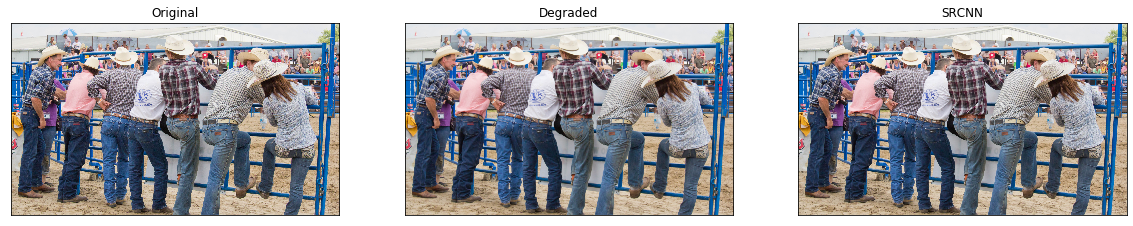

In [25]:
ref, degraded, output, scores = predict('DIV2K_LR_20/0804.png')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [26]:
# Save single reconstructed image to test in mask rcnn
cv2.imwrite('degraded_0804.png', output)

True

The PSNR in the reconstructed image is slightly larger (increase of 1.5), meaning it is a 'better/closer' reconstruction of the original image. 
(PSNR measures how much the distored image(LR or reconstructed) deviates from the original HR image)

### Predicting/Creating photos for whole set

In [124]:
for file in os.listdir('DIV2K_LR_20'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('DIV2K_LR_20/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('DIV2K_20_SRCNN/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

Saving 0801.png
Saving 0802.png
Saving 0803.png
Saving 0804.png
Saving 0805.png
Saving 0806.png
Saving 0807.png
Saving 0808.png
Saving 0809.png
Saving 0810.png
Saving 0811.png
Saving 0812.png
Saving 0813.png
Saving 0814.png
Saving 0815.png
Saving 0816.png
Saving 0817.png
Saving 0818.png
Saving 0819.png
Saving 0820.png


## SRResNet

Testing Pytorch SRResNet <br> 
Referenced from https://github.com/twtygqyy/pytorch-SRResNet

In [36]:
%cd pytorch-SRResNet-master
%pwd

C:\Users\Stephane\Desktop\DSProjects\Miro-SuperRes\pytorch-SRResNet-master


'C:\\Users\\Stephane\\Desktop\\DSProjects\\Miro-SuperRes\\pytorch-SRResNet-master'

Trying to train with own dataset as pretrained model was trained with Python2 -> caused an error "UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 918: ordinal not in range(128)"
<br>
Not enough memory to perform training(?)

In [37]:
!python main_srresnet.py --vgg_loss

Namespace(batchSize=16, cuda=False, gpus='0', lr=0.0001, nEpochs=500, pretrained='', resume='', start_epoch=1, step=200, threads=0, vgg_loss=True)
Random Seed:  879
===> Loading datasets


OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 4860 tid 13672 thread 0 bound to OS proc set 0
Traceback (most recent call last):
  File "C:\Users\Stephane\Anaconda3\envs\ftds\lib\site-packages\h5py\_hl\files.py", line 190, in make_fid
    fid = h5f.open(name, h5f.ACC_R

In [127]:
!python demo.py --model model/model_srresnet.pth --dataset DIV2K_HR_20 --image 0801

OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 1836 tid 17688 thread 0 bound to OS proc set 0
C:\Users\Stephane\Anaconda3\envs\ftds\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you c

In [ ]:
#model = torch.load(opt.model)["model"]

### SRGAN (Using ProSR/ProSRs)

Testing a pretrained SISR method. <br>
Referenced from https://github.com/fperazzi/proSR

In [129]:
%cd ../fperazzi-proSR-master
%pwd

C:\Users\Stephane\Desktop\DSProjects\Miro-SuperRes\fperazzi-proSR-master


'C:\\Users\\Stephane\\Desktop\\DSProjects\\Miro-SuperRes\\fperazzi-proSR-master'

In [131]:
!python export PYTHONPATH=/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/fperazzi-proSR-master/lib

python: can't open file 'export': [Errno 2] No such file or directory


In [132]:
!python test.py -i ../DIV2K_LR_20 -t ../DIV2K_HR_20 --checkpoint fperazzi-proSR-master/data/checkpoints/proSR.pth --scale 8

Traceback (most recent call last):
  File "test.py", line 3, in <module>
    from prosr import Phase
ModuleNotFoundError: No module named 'prosr'


## Testing Images on Mask RCNN

In [27]:
%pwd
#%cd ..

'C:\\Users\\Stephane\\Desktop\\DSProjects\\Miro-SuperRes'

##### Matterport Mask RCNN Setup (Using default classes and pretrained weights)

In [28]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN-master/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [29]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [30]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [31]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


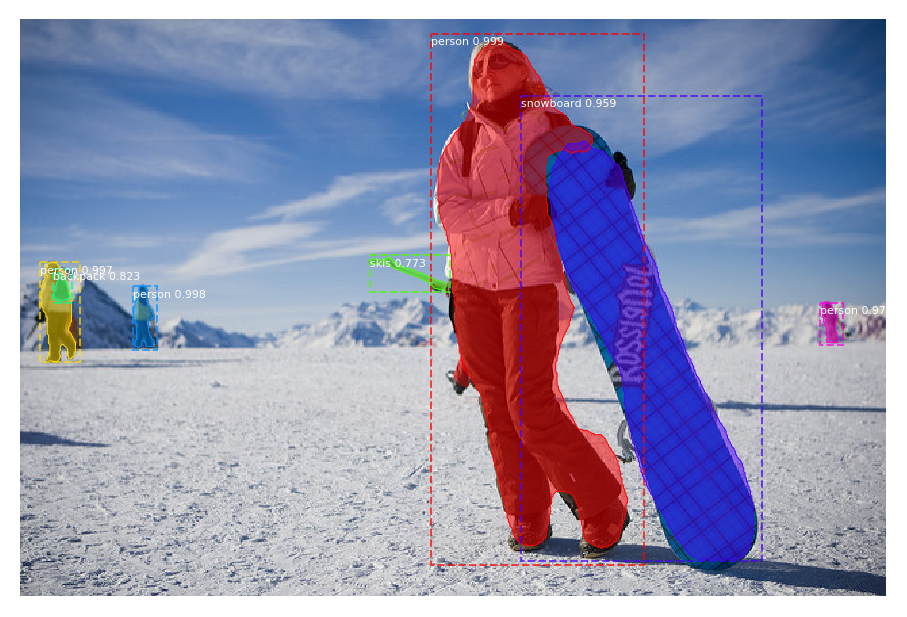

In [32]:
# TEST MASK RCNN MODEL
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Testing on LR, HR and SRCNN generated images

Processing 1 images
image                    shape: (1356, 2040, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2040.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


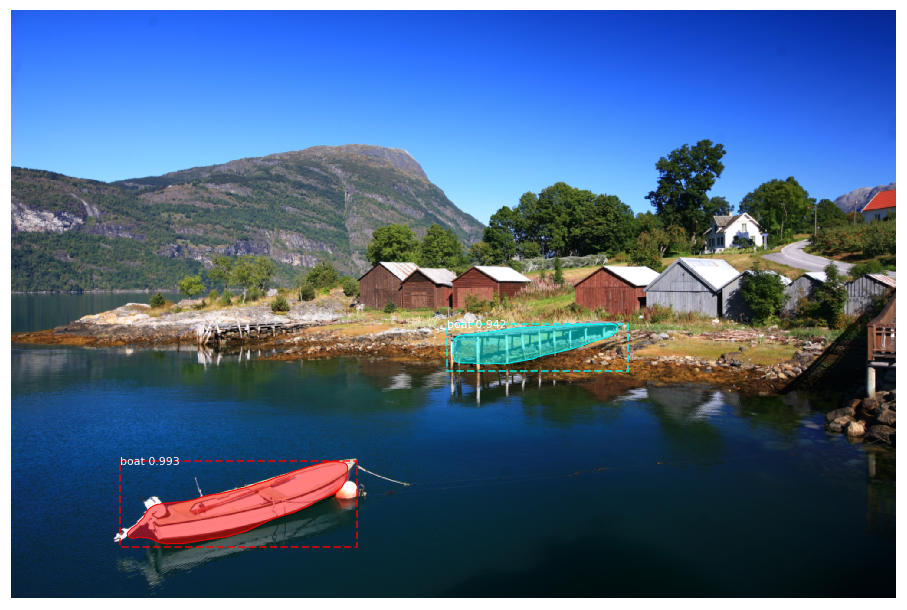

In [8]:
# TESTING ON LR Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/DIV2K_LR_20'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, '0808.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (1356, 2040, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2040.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


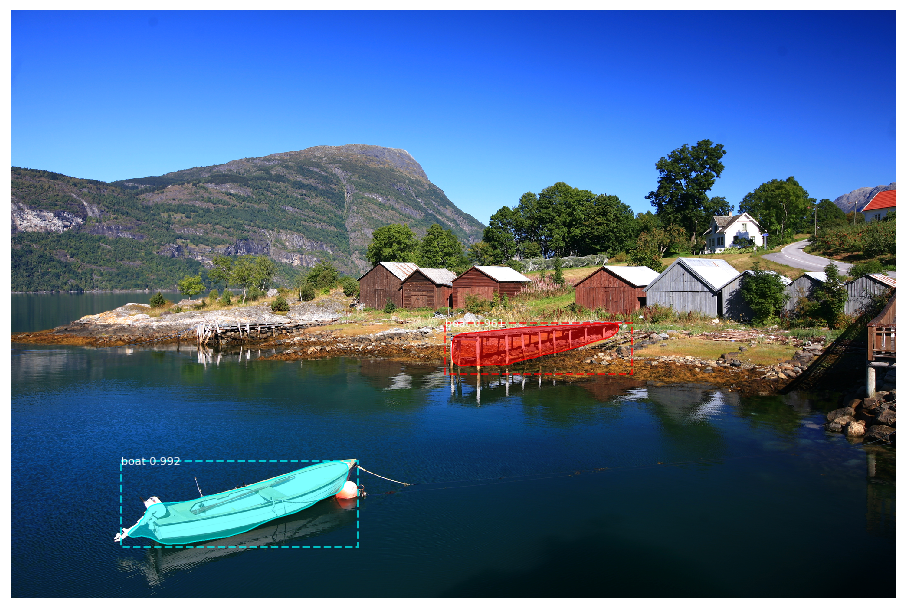

In [9]:
# TESTING ON HR Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/DIV2K_HR_20'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, '0808.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (1344, 2027, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2027.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


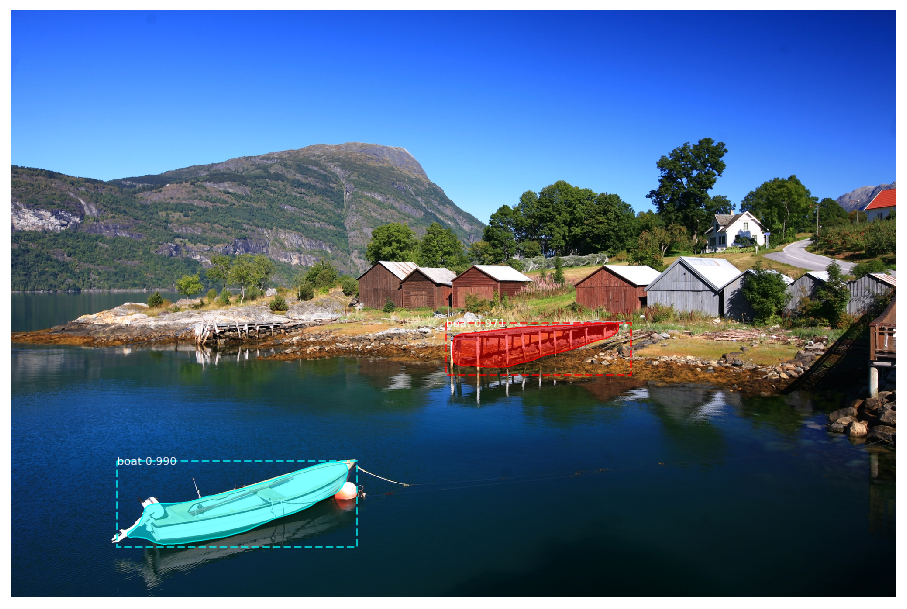

In [33]:
# TESTING ON SRCNN generated Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, 'degraded_0808.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (1200, 2040, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2040.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


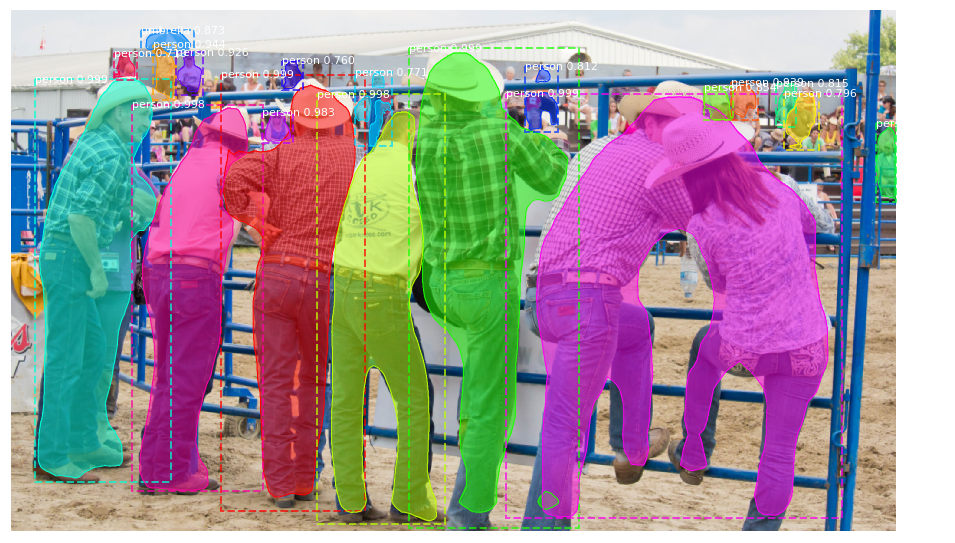

In [10]:
# TESTING ON LR Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/DIV2K_LR_20'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, '0804.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (1200, 2040, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2040.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


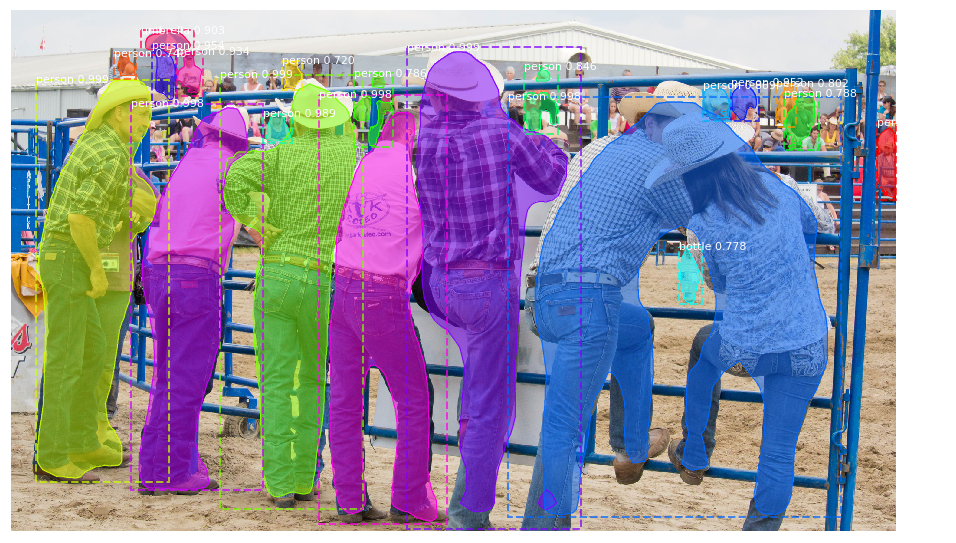

In [11]:
# TESTING ON HR Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/DIV2K_HR_20'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, '0804.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

The bottle was segmented up in the HR photo, while it was not segmented in the SR photo

Processing 1 images
image                    shape: (1188, 2027, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2027.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


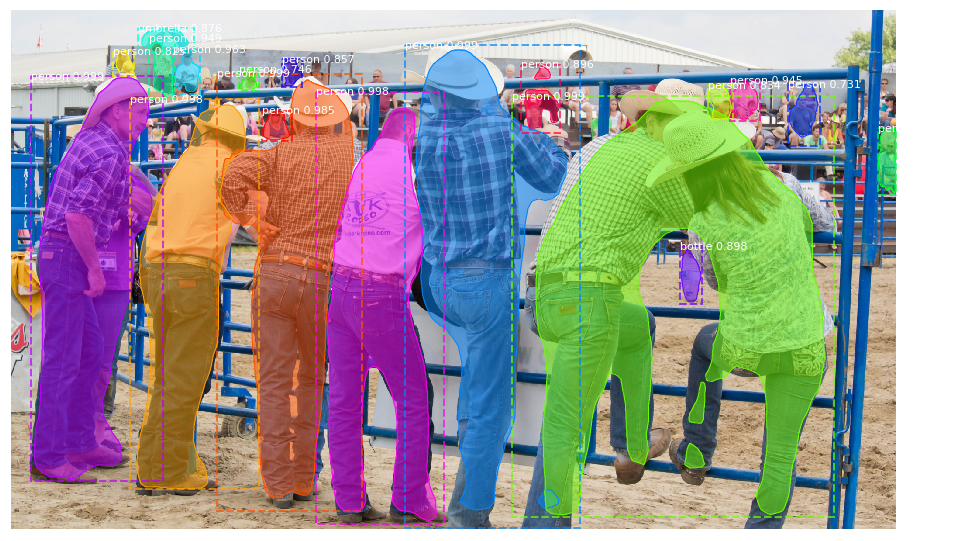

In [34]:
# TESTING ON SRCNN generated Image
TEST_IMAGE_DIR = 'C:/Users/Stephane/Desktop/DSProjects/Miro-SuperRes/'
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, 'degraded_0804.png'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

The bottle was also segmented and classified in the SRCNN generated image. Though there are obvious 'holes' in some of the masks of people. 